In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np

from sparcscore.pipeline.project import Project
from sparcscore.pipeline.workflows import CytosolSegmentationCellpose
from sparcscore.pipeline.extraction import HDF5CellExtraction
from sparcscore.pipeline.classification import CellFeaturizer
from sparcscore.pipeline.selection import LMDSelection

In [12]:
project_location = f"project"

project = Project(os.path.abspath(project_location),
                  config_path= "config_example4.yml",
                  overwrite=False,
                  debug=True,
                  segmentation_f=CytosolSegmentationCellpose,
                  extraction_f=HDF5CellExtraction,
                  classification_f=CellFeaturizer,
                  selection_f=LMDSelection
                  )

modifying config
[25/01/2024 00:15:39] Loading config from /Users/sophia/Documents/GitHub/SPARCSpy/example_data/example_4/project/config.yml
[25/01/2024 00:15:39] current run: 0


/Users/sophia/Documents/GitHub/SPARCSpy/src/sparcscore/pipeline/project.py:109: UserWarning: Theres already a directory in the location path
  warnings.warn("Theres already a directory in the location path")


In [4]:
#these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = ["./input_images/ch1.tif",
          "./input_images/ch2.tif",
          "./input_images/ch3.tif"]

project.load_input_from_file(images)

(3, 2159, 2159)


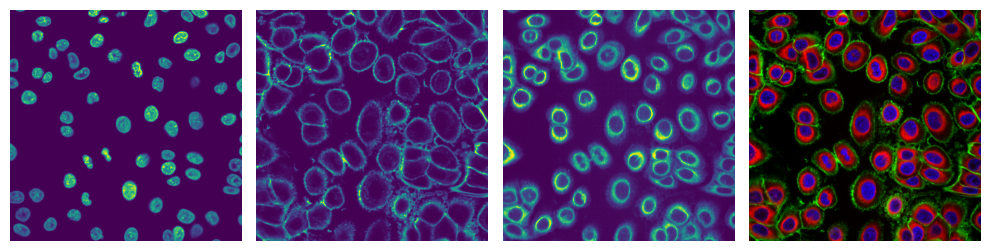

In [5]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time

def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError('This function expects a single-channel image!')

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color

def generate_composite(images, colors = [(0, 0, 1),(0, 1, 0), (1, 0, 0), (1, 0, 1)], plot = False):
    colorized = []
    for image, color in zip(images, colors):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized)-1):
        image += colorized[i+1]

    return(np.clip(image, 0, 1))

fig, axs = plt.subplots(1, 4, figsize = (10, 4));
axs[0].imshow(project.input_image[0]);
axs[0].axis("off");

axs[1].imshow(project.input_image[1]);
axs[1].axis("off");

axs[2].imshow(project.input_image[2]);
axs[2].axis("off");

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off");

fig.tight_layout()

[25/01/2024 00:11:07] current process: <_MainProcess name='MainProcess' parent=None started>
[25/01/2024 00:11:07] cpu name: MainProcess
[25/01/2024 00:11:07] running on default GPU.
[25/01/2024 00:11:07] Using MPS backend for segmentation.
[25/01/2024 00:11:07] GPU Status for segmentation: True
[25/01/2024 00:11:07] Segmenting nuclei using the following model: nuclei
[25/01/2024 00:11:30] Segmenting cytosol using the following model: cyto2
[25/01/2024 00:13:51] Number of nuclei to filter: 76


/Users/sophia/Documents/GitHub/SPARCSpy/src/sparcscore/pipeline/workflows.py:820: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


[25/01/2024 00:13:52] saving segmentation
[25/01/2024 00:13:53] === finished segmentation ===


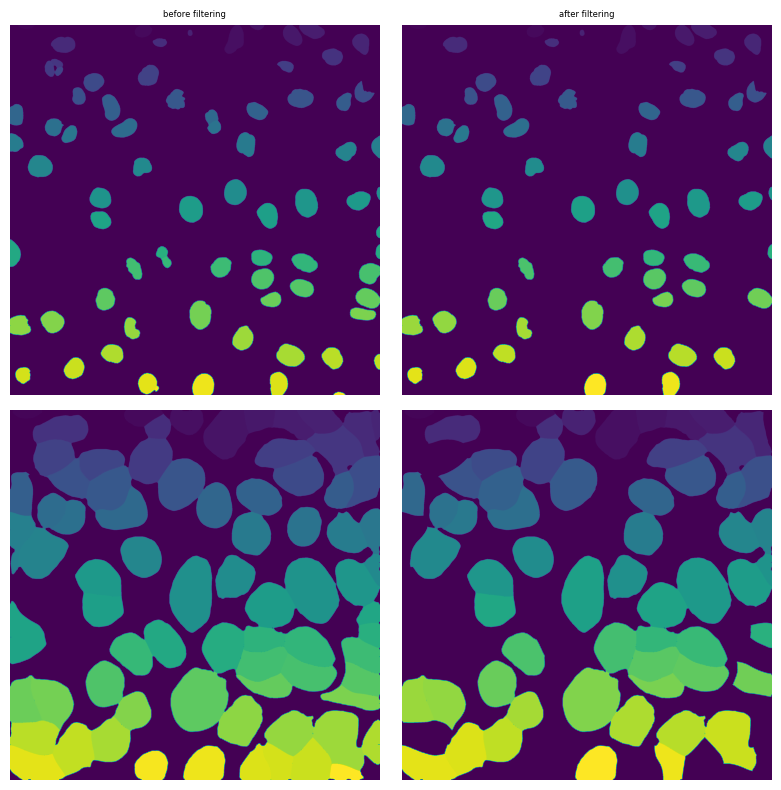

In [6]:
project.segment()

<HDF5 dataset "labels": shape (2, 2159, 2159), type "<u4">


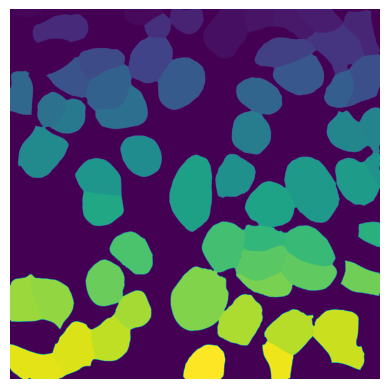

In [7]:
with h5py.File(f"{project_location}/segmentation/segmentation.h5") as hf:
    segmentation = hf.get("labels")
    print(segmentation)

    plt.figure()
    plt.imshow(segmentation[0])
    plt.axis("off")

    plt.figure()
    plt.imshow(segmentation[1])
    plt.axis("off")

In [13]:
project.extract()

/Users/sophia/Documents/GitHub/SPARCSpy/src/sparcscore/pipeline/extraction.py:408: RuntimeWarning: invalid value encountered in cast
  px_centers = np.round(center_nuclei).astype(int)


[25/01/2024 00:15:45] Using channel label <HDF5 dataset "channels": shape (3, 2159, 2159), type "<u2">
[25/01/2024 00:15:45] Using segmentation label <HDF5 dataset "labels": shape (2, 2159, 2159), type "<u4">
[25/01/2024 00:15:45] Created new extraction cache ./c8468467-b95c-434a-964a-6fcb1298e487
[25/01/2024 00:15:45] Started extraction
[25/01/2024 00:15:45] Loading segmentation data from {input_segmentation_path}
[25/01/2024 00:15:45] Using channel label <HDF5 dataset "channels": shape (3, 2159, 2159), type "<u2">
[25/01/2024 00:15:45] Using segmentation label <HDF5 dataset "labels": shape (2, 2159, 2159), type "<u4">
[25/01/2024 00:15:45] Finished loading channel data (3, 2159, 2159)
[25/01/2024 00:15:45] Finished loading label data (2, 2159, 2159)
[25/01/2024 00:15:45] Checked class coordinates
[25/01/2024 00:15:45] Cached version found, loading
[25/01/2024 00:15:45] Loading filtered classes from /Users/sophia/Documents/GitHub/SPARCSpy/example_data/example_4/project/segmentation/cl

extracting classes: 13it [00:00, 105.84it/s]

[25/01/2024 00:15:45] Extracting dataset 0


extracting classes: 60it [00:01, 30.12it/s] 


[25/01/2024 00:15:47] Finished extraction in 2.00 seconds (30.05 cells / second)
[25/01/2024 00:15:47] Collect cells
[25/01/2024 00:15:47] number of cells too close to image edges to extract: 25
[25/01/2024 00:15:47] Transferring extracted single cells to .hdf5
[25/01/2024 00:15:47] index created.
[25/01/2024 00:15:48] Tempmmap Folder location /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./temp_mmap3quuio5j will now be removed.
[25/01/2024 00:15:48] Finished cleaning up cache


(35, 5, 400, 400)


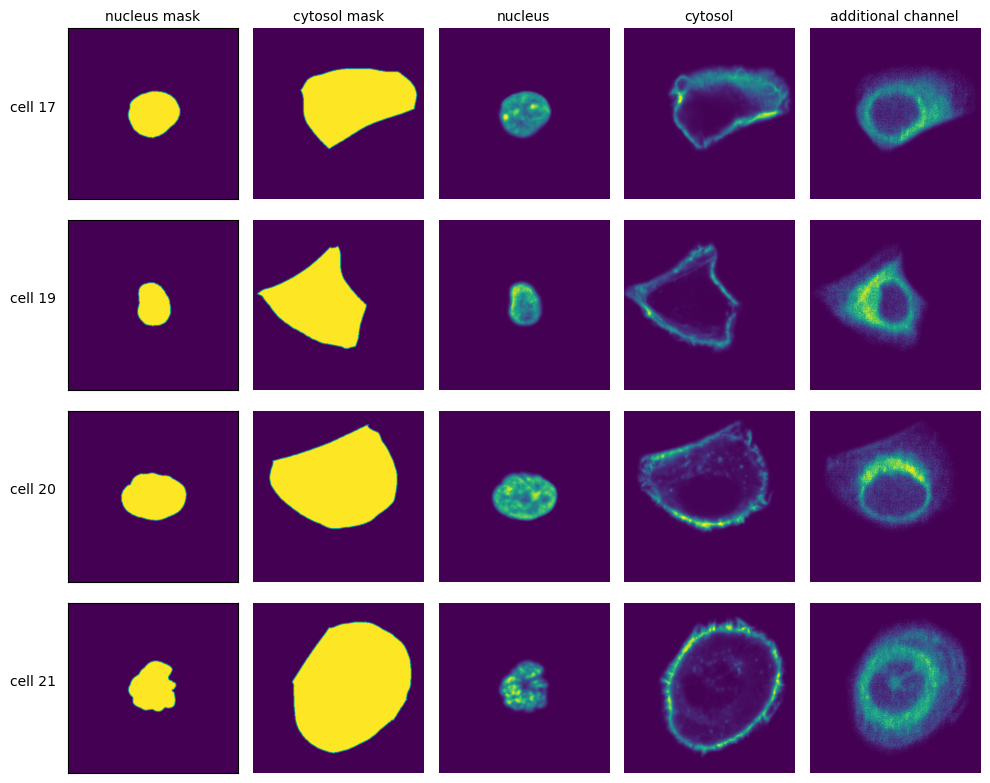

In [14]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize = (5*2, len(n_cells)*2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]
    
    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize = 10, rotation = 0, labelpad = 25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")
        
            if i == 0:
                axs[i, n].set_title(labels[n], fontsize = 10)
            
            
    fig.tight_layout()

In [15]:
project.classify(accessory = [(), (), ()])

[25/01/2024 00:15:55] Started classification
[25/01/2024 00:15:55] starting with run 0
[25/01/2024 00:15:55] channel_classification: 4
[25/01/2024 00:15:55] batch_size: 900
[25/01/2024 00:15:55] dataloader_worker: 0
[25/01/2024 00:15:55] inference_device: cpu
[25/01/2024 00:15:55] screen_label: Ch3_Featurization
[25/01/2024 00:15:55] 0 different accessory datasets specified
[25/01/2024 00:15:55] loading /Users/sophia/Documents/GitHub/SPARCSpy/example_data/example_4/project/extraction/data
[25/01/2024 00:15:55] Total: 35
[25/01/2024 00:15:55] 0: 35
[25/01/2024 00:15:55] 
[25/01/2024 00:15:55] start processing 1 batches
[25/01/2024 00:15:55] finished processing


/Users/sophia/mambaforge/envs/SPARCS-dev/lib/python3.10/site-packages/torch/masked/maskedtensor/core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "


In [16]:
#load classification results
results = pd.read_csv(f"{project_location}/classification/0_Ch3_Featurization/calculated_features.tsv", index_col = 0)
results

nucleus_area  cytosol_area      mean        median   quant75  \
0        11397.0       41617.0  0.081392  0.000000e+00  0.023899   
1         9520.0       47419.0  0.095464  0.000000e+00  0.052063   
2        11124.0       46609.0  0.062010  0.000000e+00  0.044098   
3        13652.0       48209.0  0.082474  0.000000e+00  0.062386   
4        13528.0       77423.0  0.080436  2.241135e-03  0.116394   
5        13325.0       56724.0  0.089362  0.000000e+00  0.107117   
6         8532.0       30017.0  0.054597  0.000000e+00  0.000067   
7        13991.0       55129.0  0.114541  0.000000e+00  0.142822   
8        13886.0       53559.0  0.092906  0.000000e+00  0.107117   
9        17487.0       47697.0  0.080080  0.000000e+00  0.062500   
10       15414.0       61864.0  0.100614  7.152557e-07  0.115295   
11       18687.0       55875.0  0.093190  0.000000e+00  0.107117   
12       13974.0       48755.0  0.063006  0.000000e+00  0.050636   
13       19189.0      101554.0  0.117772  4.718018e-02  0.149536   
14       19169.0       85260.0  0.135075  2.935791e-02  0.196045   
15       11528.0       67747.0  0.120031  1.171231e-04  0.209961   
16        9849.0       29429.0  0.057274  0.000000e+00  0.000001   
17       19602.0       91857.0  0.131233  3.771973e-02  0.169800   
18       10926.0       33188.0  0.075090  0.000000e+00  0.005990   
19       13139.0       48301.0  0.083832  0.000000e+00  0.090088   
20       14920.0       53215.0  0.070493  0.000000e+00  0.076965   
21       10642.0       48310.0  0.084110  0.000000e+00  0.062317   
22        8182.0       27872.0  0.049045  0.000000e+00  0.000000   
23       13008.0       49163.0  0.072528  0.000000e+00  0.062469   
24       13395.0       48054.0  0.079783  0.000000e+00  0.062500   
25       15091.0       59838.0  0.085869  5.960465e-08  0.089172   
26       15410.0       55199.0  0.079973  0.000000e+00  0.089294   
27       11733.0       37461.0  0.062616  0.000000e+00  0.014139   
28        7681.0       36160.0  0.068931  0.000000e+00  0.007214   
29        5762.0       47573.0  0.072869  0.000000e+00  0.080261   
30       12679.0       59605.0  0.113194  0.000000e+00  0.125000   
31        9568.0       30992.0  0.047519  0.000000e+00  0.001004   
32       14563.0       47217.0  0.086133  0.000000e+00  0.125000   
33        9978.0       38689.0  0.061748  0.000000e+00  0.006456   
34       13241.0       52101.0  0.083230  0.000000e+00  0.061928   

         quant25  summed_intensity_nucleus_area  \
0   0.000000e+00                      3611.5560   
1   0.000000e+00                      3745.5317   
2   0.000000e+00                      3318.8823   
3   0.000000e+00                      4596.3690   
4   0.000000e+00                      3154.8610   
5   0.000000e+00                      3738.9450   
6   0.000000e+00                      2562.3862   
7   0.000000e+00                      3797.9897   
8   0.000000e+00                      4265.4043   
9   0.000000e+00                      6033.7130   
10  0.000000e+00                      4399.1494   
11  0.000000e+00                      5146.0400   
12  0.000000e+00                      3732.5452   
13  3.576279e-07                      4107.2230   
14  0.000000e+00                      5188.4165   
15  0.000000e+00                      2618.5325   
16  0.000000e+00                      3318.6487   
17  0.000000e+00                      4939.0050   
18  0.000000e+00                      4159.0430   
19  0.000000e+00                      3381.3418   
20  0.000000e+00                      3229.7104   
21  0.000000e+00                      3837.0107   
22  0.000000e+00                      2927.5460   
23  0.000000e+00                      4248.8270   
24  0.000000e+00                      3565.4822   
25  0.000000e+00                      6941.0146   
26  0.000000e+00                      4728.4165   
27  0.000000e+00                      2980.9824   
28  0.000000e+00                      1996.1312   
29  0.000000e+00         

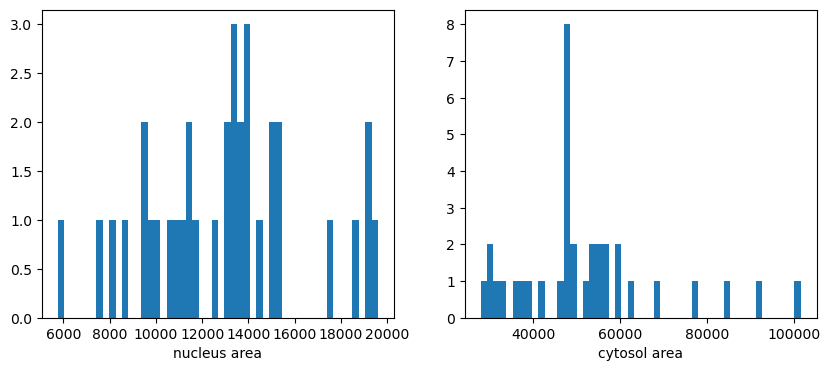

In [22]:
fig, axs = plt.subplots(1, 2, figsize = (10, 4))
axs[0].hist(results["nucleus_area"], bins = 50)
axs[0].set_xlabel("nucleus area");

axs[1].hist(results["cytosol_area"], bins = 50)
axs[1].set_xlabel("cytosol area");